# **Number classification algorithm**

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [10]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

from sklearn.externals import joblib
import string

In [11]:
class Digit:
    def __init__(self, data, target):
        self.target = target
        self.width  = int(np.sqrt(len(data)))
        self.image  = data.reshape(self.width, self.width)
        self.features = {'var' : 0,
                         'std' : 0,
                         'mean_grad_M' : 0,
                         'std_grad_M'  : 0,
                         'mean_grad_D' : 0,
                         'std_grad_D'  : 0,
                         'mean_PC_X'   : 0,
                         'std_PC_X'    : 0,
                         'active_PC_X' : 0,
                         'mean_PC_Y'   : 0,
                         'std_PC_Y'    : 0,
                         'active_PC_Y' : 0}
        self.computeFeatures()
    
    def computeFeatures(self):
        # Feature computation
        mag, ang = sobel(self.image)
        pcx, pcy = pixel_count(self.image)
        
        self.features['var'] = np.var(self.image)
        self.features['std'] = np.std(self.image)
        self.features['mean_grad_M'] = np.mean(mag)
        self.features['std_grad_M'] =  np.std(mag)
        self.features['mean_grad_D'] = np.mean(ang)
        self.features['std_grad_D'] =  np.std(ang)
        self.features['mean_PC_X'] =   np.mean(pcx)
        self.features['std_PC_X'] =    np.std(pcx)
        self.features['active_PC_X'] = np.count_nonzero(pcx)
        self.features['mean_PC_Y'] =   np.mean(pcy)
        self.features['std_PC_Y'] =    np.std(pcy)
        self.features['active_PC_Y'] = np.count_nonzero(pcy) 
  
    def __print__(self):
        print("Digit target: "+str(self.target))
        print("Digit features:")
        print(self.features)
        print("Digit image:")
        plt.gray()
        plt.matshow(self.image) 
        plt.show()

In [12]:
def sobel(image):
    w = len(image)
    kernel_x = np.array([ [ 1, 0,-1],
                          [ 2, 0,-2],
                          [ 1, 0,-1] ])

    kernel_y = np.array([ [ 1, 2, 1],
                          [ 0, 0, 0],
                          [-1,-2,-1] ])
    
    grad_x = np.zeros([w - 2, w - 2])
    grad_y = np.zeros([w - 2, w - 2])
    
    for i in range(w - 2):
        for j in range(w - 2):
            grad_x[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_x))
            grad_y[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_y))
            if grad_x[i, j] == 0:
                grad_x[i, j] = 0.000001 
    
    mag = np.sqrt(grad_y ** 2 + grad_x ** 2)
    ang = np.arctan(grad_y / (grad_x + np.finfo(float).eps))
  
    # Gradient computation
  
    return [mag,ang]

def pixel_count(image):
    pc_x = np.zeros(len(image))
    pc_y = np.zeros(len(image))
  
    # Pixel count computation
    for i in range(len(image)):
        pc_x[i] = np.count_nonzero(image[i, :])
        pc_y[i] = np.count_nonzero(image[:, i])

    return [pc_x, pc_y]

In [13]:
class Dataset:
    def __init__(self, array, length):  
        self.array = array
        self.length = length
        self.digits = []
        self.digits = self.createDigits()
        self.raw_features = [[float(f) for f in dig.features.values()] for dig in self.digits]
        self.raw_targets  = [[self.digits[i].target] for i in range(self.length)]
  
    def createDigits(self):
        digits = []
        for row in self.array:
            digits.append(Digit(np.array(row[:-1]), row[-1]))
        return digits

# Generate datasets

In [14]:
# n : percent of the number of lines in the data base use as array set
def load_data_set(array, n):
    dataset = Dataset(array[:int(n * len(array))], int(n * len(array)))
    return dataset

In [15]:
%%time

#Load the database (.npy) files 
img_array_test = np.load('./../../test.npy')


CPU times: user 1.23 ms, sys: 16.6 ms, total: 17.9 ms
Wall time: 16.5 ms


In [16]:
%%time 

print("Creating testing dataset")
print("Number of the lines in the test dataset: " + str(len(img_array_test)))
testing_set = load_data_set(img_array_test, 1)
print ("Number of the lines in the test dataset: " + str(testing_set.length))
print ("\nFinished creating test dataset\n")

Creating testing dataset
Number of the lines in the test dataset: 6150
Number of the lines in the test dataset: 6150

Finished creating test dataset

CPU times: user 1min 9s, sys: 174 ms, total: 1min 9s
Wall time: 1min 9s


In [57]:
'''
for i in range(0,5):
    validation_set.digits[i].__print__()
'''

'\nfor i in range(0,5):\n    validation_set.digits[i].__print__()\n'

In [17]:
def cvt_obj_nparray(dataset):
    X = np.zeros((dataset.length, 12))
    Y = np.zeros((dataset.length,))
    for i, digit in enumerate(dataset.digits):
        Y[i] = digit.target
        for j, feature in enumerate(digit.features):
            X[i, j] = digit.features[feature]
    return X, Y

In [18]:
%%time

#The X_dataset and Y_dataset are the lists used in the classifier
print("Creating X_dataset and Y_dataset")
X_test, Y_test = cvt_obj_nparray(testing_set)
print("Finished X_dataset and Y_dataset\n")

Creating X_dataset and Y_dataset
Finished X_dataset and Y_dataset

CPU times: user 32.9 ms, sys: 3.92 ms, total: 36.8 ms
Wall time: 34.3 ms


# **KK Neighborhod algorithm**

In [26]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = string.ascii_uppercase
    
    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.figure(figsize=(15,12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Load classifier

In [20]:
# load first knn classifier
first_classifier = './knn_classifier.sav'
knn_classificator = joblib.load(first_classifier)


In [21]:
knn_classificator

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
# load best knn classifier
best_classifier = './best_knn_classifier.sav'
best_knn_classificator = joblib.load(best_classifier)

In [23]:
best_knn_classificator

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=29, p=2,
           weights='distance')

In [27]:
result = knn_classificator.score(X_test, Y_test)
print(str(round(result * 100, 3)) + "%")

14.341%


In [28]:
best_result = best_knn_classificator.score(X_test, Y_test)
print(str(round(best_result * 100, 3)) + "%")

17.236%


In [33]:
# Compute prediction accuracy on testing set
def test_knnModel(clf, nom):
    predicted = clf.predict(X_test)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_test)) + " images")
    
    plot_confusion_matrix(clf, X_test, Y_test)
    plt.title('Test confusion matrix: accuracy of ' + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%, used " + str(len(X_test)) + " images")
    plt.savefig(nom)
    #plt.show()

The accuracy for test database is: 14.341%
Using: 6150 images


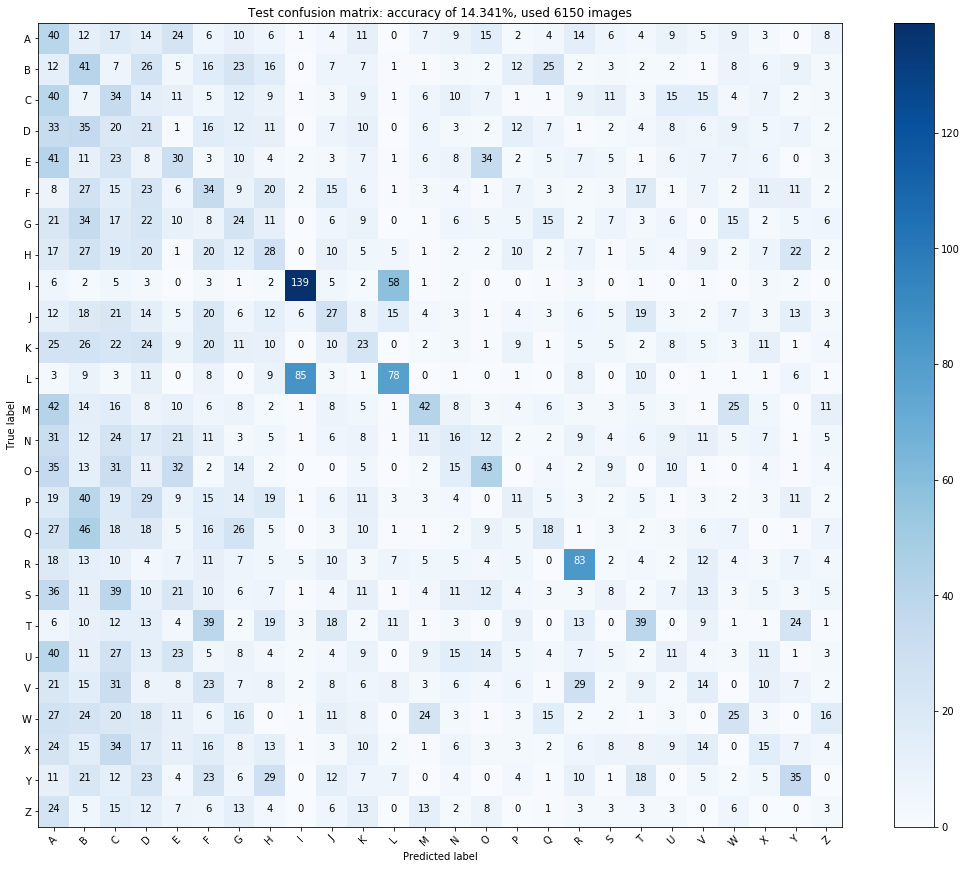

In [66]:
test_knnModel(knn_classificator, './test_simple_classifier')

The accuracy for test database is: 17.236%
Using: 6150 images


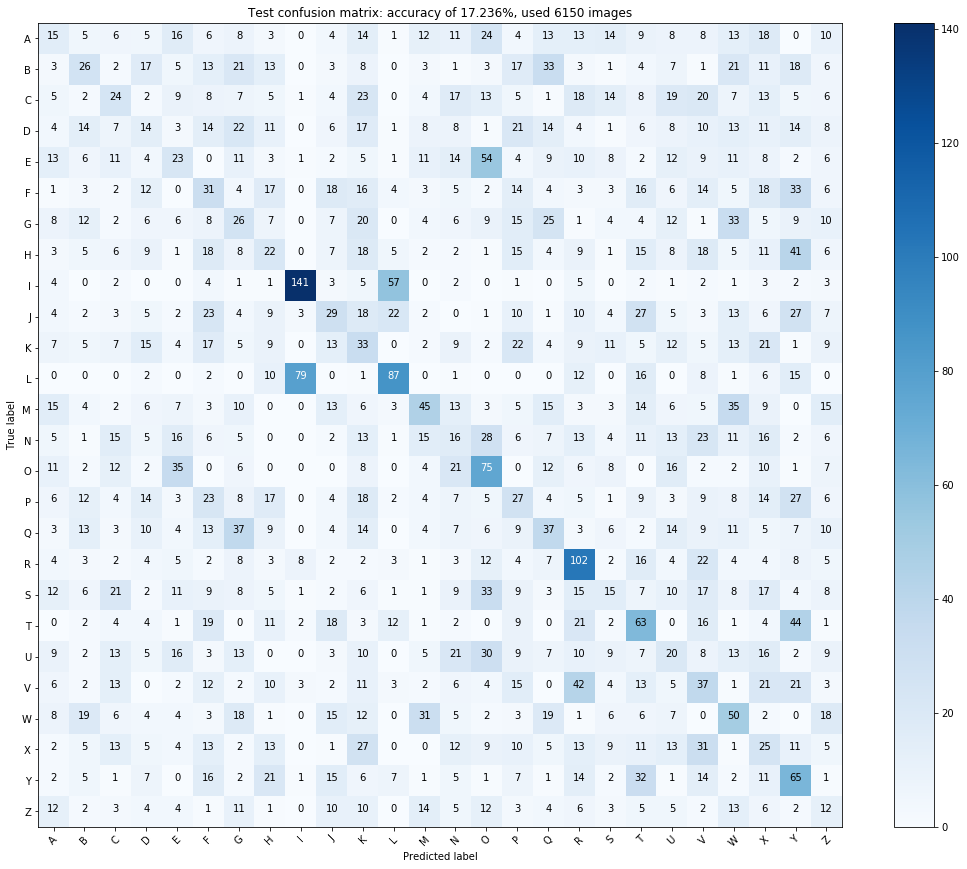

In [67]:
test_knnModel(best_knn_classificator, './test_best_classifier')

# Application 

In [75]:
%%time

#Load the database (.npy) files 
img_array_photos = np.load('./../photos/test_photos.npy')

CPU times: user 249 µs, sys: 44.1 ms, total: 44.4 ms
Wall time: 44.5 ms


In [76]:
%%time 

print("Creating validation dataset...")
print("Number of the lines in the validation dataset: " + str(len(img_array_photos)))
photos_set = load_data_set(img_array_photos, 1)
print ("Number of the lines in the validation dataset: " + str(photos_set.length))
print ("\nFinished creating validation dataset\n")

Creating validation dataset...
Number of the lines in the validation dataset: 18720
Number of the lines in the validation dataset: 18720

Finished creating validation dataset

CPU times: user 3min 45s, sys: 225 ms, total: 3min 45s
Wall time: 3min 45s


In [77]:
%%time

#The X_dataset and Y_dataset are the lists used in the classifier
print("Creating X_dataset and Y_dataset")
X_photos, Y_photos = cvt_obj_nparray(photos_set)
print("Finished X_dataset and Y_dataset\n")

Creating X_dataset and Y_dataset
Finished X_dataset and Y_dataset

CPU times: user 83.1 ms, sys: 4.12 ms, total: 87.3 ms
Wall time: 85.2 ms


In [78]:
'''
for i in range(0,5):
    photos_set.digits[i].__print__()
'''

'\nfor i in range(0,5):\n    photos_set.digits[i].__print__()\n'

In [79]:
# Compute prediction accuracy on testing set
def photos_knnModel(clf, nom):
    predicted = clf.predict(X_photos)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_photos, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_photos)) + " images")
    
    plot_confusion_matrix(clf, X_photos, Y_photos)
    plt.title('Photos confusion matrix: accuracy of ' + str(round((accuracy_score(Y_photos, predicted) * 100), 3)) + "%, used " + str(len(X_photos)) + " images")
    plt.savefig(nom)

The accuracy for test database is: 8.248%
Using: 18720 images


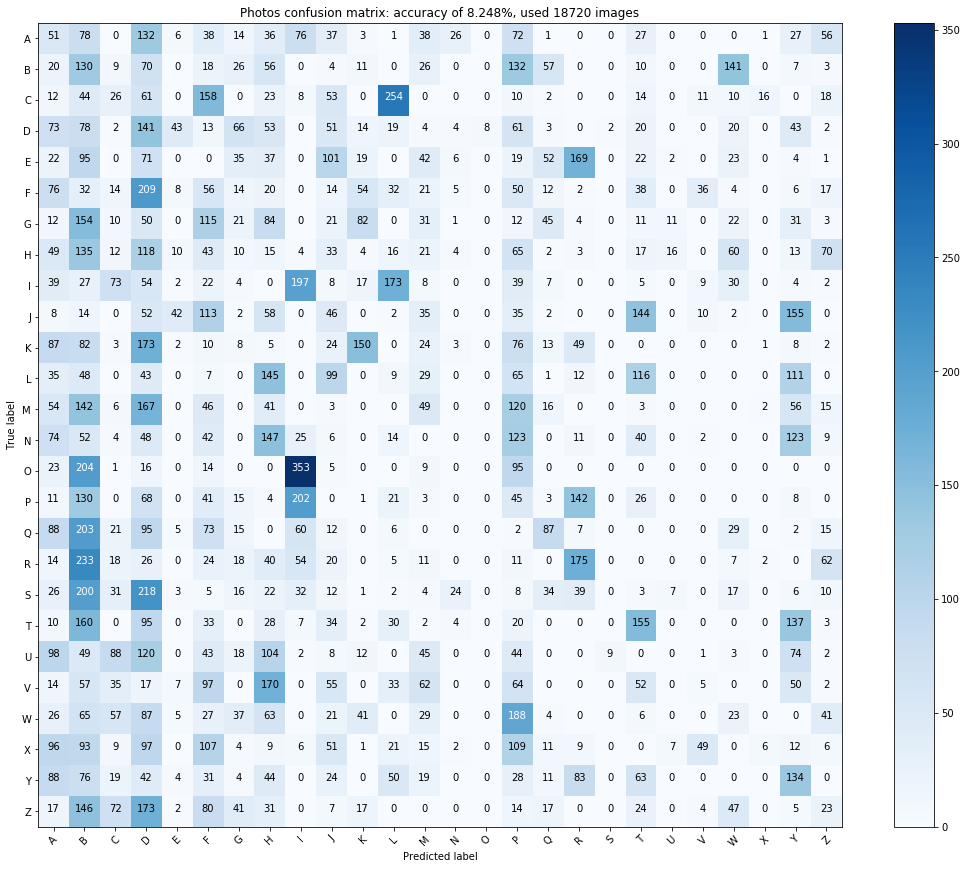

In [80]:
photos_knnModel(knn_classificator, './photos_simple_classifier')

The accuracy for test database is: 8.819%
Using: 18720 images


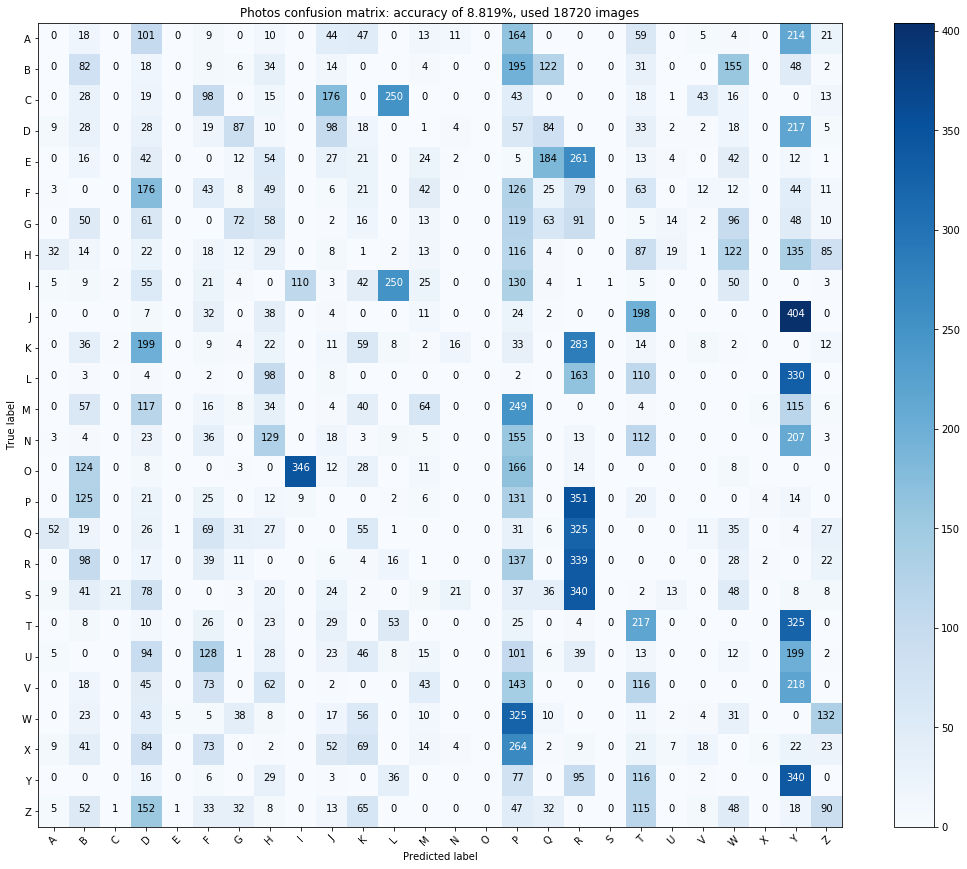

In [81]:
photos_knnModel(best_knn_classificator, './photos_best_classifier')